In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from datetime import datetime
import plotly.offline as py
py.init_notebook_mode(connected=True)

### Importing Data and Making it into TS Data

In [19]:
data= pd.read_csv("../data/data.csv")
new= pd.read_excel("../data/DSA3101_Hackathon_Panelists_Demographics.xlsx")

In [20]:
data["ID"] = data["Panel ID"]
data.drop("Panel ID", axis=1)

,Date,Category,Pack Size,Volume,Spend,Ratio,Product,Week,ID
0,2017-06-25,Frozen Food,1,0.5,5.8,11.60,Frozen Food_11.6,0,Panel 317007101
1,2017-06-25,Flour,1,1.0,3.7,3.70,Flour_3.7,0,Panel 322018102
2,2017-06-25,Cooking Oils,2,2.0,5.0,2.50,Cooking Oils_2.5,0,Panel 322018102
3,2017-06-25,Snack,5,0.1,2.0,20.00,Snack_20.0,0,Panel 323010101
4,2017-06-25,Snack,5,0.1,2.0,20.00,Snack_20.0,0,Panel 323010101
...,...,...,...,...,...,...,...,...,...
1300582,2020-06-14,Instant Noodles,2,0.6,7.5,12.50,Instant Noodles_12.5,155,Panel 407025101
1300583,2020-06-14,Cordials,1,0.3,5.3,17.67,Cordials_17.67,155,Panel 407025101
1300584,2020-06-14,Biscuits,2,0.2,4.0,20.00,Biscuits_20.0,155,Panel 407025101
1300585,2020-06-14,Milk Powder-Infant,2,1.8,51.9,28.83,Milk Powder-Infant_28.83,155,Panel 801065801


In [21]:
df = pd.merge(data,new,how = 'inner', on = ['ID'])

In [22]:
df = df.drop(["Strata","Product","Pack Size","Volume","Spend","Ratio","ID","BMI","Income","Ethnicity","Lifestage","#HH","Panel ID"],axis = 1)

* Train Set: Week 1 to week 143 
* Test Set: Week 143 to week 155
* Forecast lag size = 12 (3 months)

In [23]:
df = df.groupby(['Category', 'location', 'Date']).size().reset_index(name='sales')

In [24]:
train = df[(df['Date'] <= '2020-03-16')]
test = df[(df['Date'] >'2020-03-16')]

## EDA for TS data

In [25]:
location = 'North' ## probably can make some streamlit app to make it automated 
item = 'Yoghurts'

In [26]:
store_item_df = train.copy()
# First, let us filterout the required data
store_id = '{}'.format(location)   # Some store
item_id = '{}'.format(item)    # Some item
print('Before filter:', store_item_df.shape)
store_item_df = store_item_df[store_item_df.location == store_id]
store_item_df = store_item_df[store_item_df.Category == item_id]
print('After filter:', store_item_df.shape)
#display(store_item_df.head())

# Let us plot this now
store_item_ts_data = [go.Scatter(
    x=store_item_df.Date,
    y=store_item_df.sales)]
py.iplot(store_item_ts_data)

Before filter: (32891, 4)
After filter: (143, 4)


In [27]:
multi_store_item_df = train.copy()
# First, let us filterout the required data
store_ids = ['North', 'South', 'Central', 'East Coast']   # Some stores
item_ids = ['Yoghurts', 'Yoghurts', 'Yoghurts', 'Yoghurts']    # Some items
print('Before filter:', multi_store_item_df.shape)
multi_store_item_df = multi_store_item_df[multi_store_item_df.location.isin(store_ids)]
multi_store_item_df = multi_store_item_df[multi_store_item_df.Category.isin(item_ids)]
print('After filter:', multi_store_item_df.shape)
#display(multi_store_item_df)
# TODO Monthly avg sales

# Let us plot this now
multi_store_item_ts_data = []
for st,it in zip(store_ids, item_ids):
    flt = multi_store_item_df[multi_store_item_df.location == st]
    flt = flt[flt.Category == it]
    multi_store_item_ts_data.append(go.Scatter(x=flt.Date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
py.iplot(multi_store_item_ts_data)

Before filter: (32891, 4)
After filter: (570, 4)


### How does sales vary across stores

In [28]:
store_df = train.copy()
sales_pivoted_df = pd.pivot_table(store_df, index='location', values=['sales','Date'], columns='Category', aggfunc=np.mean)
# Pivoted dataframe
display(sales_pivoted_df)

sales                                                        \
Category   Baby Cereal      Beer    Belacan Bird Nest    Biscuits    Bouilon   
location                                                                       
Central       2.511811  7.471831   3.090226  1.385965  252.482517  41.538462   
East Coast    1.436782  2.112676   2.757353  1.058824  119.293706  19.629371   
North         2.700730  5.446809  10.279720  1.309091  191.482517  35.804196   
South         1.669811  3.183824   3.350365  1.209302  118.573427  19.615385   

                                                            ...              \
Category       Butter        CSD       Cake Canned Product  ...       Snack   
location                                                    ...               
Central     18.888112  40.867133  16.419580      88.041958  ...  171.972028   
East Coast   4.894366  11.811189  11.489510      27.538462  ...   73.146853   
North       11.258741  27.944056  10.804196      67.636364  ...  115.006993   
South        5.271429  16.944056   8.426573      42.741259  ...   80.314685   

                                                                   \
Category     Soy Milk   Spagetti   Spirits       Sugar        Tea   
location                                                            
Central     21.300699  24.132867  1.260000  111.139860  40.489510   
East Coast   7.566434   6.091549  1.000000   96.538462  32.545455   
North       14.650350  10.146853  1.285714  148.132867  40.671329   
South        8.069930   7.769231  1.083333   53.069930  19.195804   

                                                                
Category   Tonic Food Drink      Wine Yoghurt Drink   Yoghurts  
location                                                        
Central           87.776224  1.542373     16.692308  23.839161  
East Coast        52.524476  1.000000      7.091549   5.319149  
North             86.188811  1.383562     12.188811  11.034965  
South             37.377622  1.052632      6.405594   9.671329  

[4 rows x 62 columns]

In [29]:
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [30]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

### How does sales vary across items

In [34]:
# Let us calculate the average sales of each of the item across all the stores
sales_across_item_df = sales_pivoted_df.copy()
# Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc['total'] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
# Note the 11th index row, which is the average sale of each of the item across all the stores
#display(sales_across_item_df.loc[11:])
a = pd.DataFrame(sales_across_item_df.values[4])
b = pd.DataFrame(train.Category.unique())
result = pd.concat([b,a], axis=1, sort=False)
new = result.to_numpy()
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i,a] for i,a in new], columns=['Category', 'avg_sale'])
# And finally, sort by avg sale
avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
# Display the top 10 rows
display(avg_sales_per_item_across_stores_df.head())

,Category,avg_sale
4,Biscuits,170.458042
26,Eggs,152.111888
21,Cooking Sauces,122.886364
34,Instant Noodles,112.024476
52,Snack,110.110140


In [35]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in avg_sales_per_item_across_stores_df.Category.values],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.Category.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

## Neural Network Models

In [36]:
train_gp = train.sort_values('Date').groupby(['Category', 'location', 'Date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['Category', 'location', 'Date', 'sales']
train_gp.head()

,Category,location,Date,sales
0,Baby Cereal,Central,2017-06-25,4
1,Baby Cereal,Central,2017-07-02,3
2,Baby Cereal,Central,2017-07-09,4
3,Baby Cereal,Central,2017-07-16,3
4,Baby Cereal,Central,2017-07-23,2


In [37]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
window = 29
lag_size = 90
lag = 90
series = series_to_supervised(train_gp.drop('Date', axis=1), window=window, lag=lag)
series.head()

,Category(t-29),location(t-29),sales(t-29),Category(t-28),location(t-28),sales(t-28),Category(t-27),location(t-27),sales(t-27),Category(t-26),...,sales(t-2),Category(t-1),location(t-1),sales(t-1),Category(t),location(t),sales(t),Category(t+90),location(t+90),sales(t+90)
29,Baby Cereal,Central,4.0,Baby Cereal,Central,3.0,Baby Cereal,Central,4.0,Baby Cereal,...,2.0,Baby Cereal,Central,1.0,Baby Cereal,Central,2,Baby Cereal,Central,4.0
30,Baby Cereal,Central,3.0,Baby Cereal,Central,4.0,Baby Cereal,Central,3.0,Baby Cereal,...,1.0,Baby Cereal,Central,2.0,Baby Cereal,Central,2,Baby Cereal,Central,3.0
31,Baby Cereal,Central,4.0,Baby Cereal,Central,3.0,Baby Cereal,Central,2.0,Baby Cereal,...,2.0,Baby Cereal,Central,2.0,Baby Cereal,Central,2,Baby Cereal,Central,4.0
32,Baby Cereal,Central,3.0,Baby Cereal,Central,2.0,Baby Cereal,Central,1.0,Baby Cereal,...,2.0,Baby Cereal,Central,2.0,Baby Cereal,Central,1,Baby Cereal,Central,1.0
33,Baby Cereal,Central,2.0,Baby Cereal,Central,1.0,Baby Cereal,Central,3.0,Baby Cereal,...,2.0,Baby Cereal,Central,1.0,Baby Cereal,Central,3,Baby Cereal,Central,1.0


In [39]:
last_item = 'Category(t-%d)' % window
last_store = 'location(t-%d)' % window

In [40]:
item = 'Yoghurts'

In [41]:
new = series[series["Category(t-29)"] == '{}'.format(item)]

In [42]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Category', 'location']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Category', 'location']]
new.drop(columns_to_drop, axis=1, inplace=True)
new.drop(['Category(t)', 'location(t)'], axis=1, inplace=True)

In [43]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = new[labels_col]
new= new.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(new, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (270, 30)
Validation set shape (181, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
32526,1.0,8.0,5.0,9.0,6.0,4.0,8.0,8.0,6.0,4.0,...,4.0,6.0,5.0,4.0,8.0,7.0,6.0,2.0,7.0,4
32548,5.0,4.0,8.0,7.0,6.0,2.0,7.0,4.0,8.0,3.0,...,5.0,2.0,5.0,4.0,4.0,4.0,2.0,5.0,1.0,3
32466,34.0,22.0,35.0,24.0,35.0,26.0,16.0,30.0,28.0,21.0,...,21.0,26.0,33.0,25.0,37.0,23.0,32.0,3.0,6.0,3
32518,7.0,10.0,7.0,9.0,4.0,11.0,7.0,9.0,1.0,8.0,...,4.0,4.0,8.0,2.0,4.0,5.0,2.0,9.0,4.0,6
32724,15.0,12.0,17.0,6.0,9.0,8.0,12.0,8.0,4.0,10.0,...,19.0,7.0,10.0,12.0,14.0,9.0,7.0,8.0,12.0,6


In [44]:
import time
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns

from fastai.imports import *
from fbprophet import Prophet

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

import statsmodels.api as sm
# Initialize plotly
init_notebook_mode(connected=True)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [45]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [49]:
new = df[df["Category"] == "Yoghurts"]
df_raw = df.copy()
df_raw = df_raw.set_index("Date")
df_raw.index = pd.to_datetime(df_raw.index, format='%Y-%m-%d')


In [50]:
df_raw

,Category,location,sales
Date,,,
2017-06-25,Baby Cereal,Central,4
2017-07-02,Baby Cereal,Central,3
2017-07-09,Baby Cereal,Central,4
2017-07-16,Baby Cereal,Central,3
2017-07-23,Baby Cereal,Central,2
...,...,...,...
2020-05-17,Yoghurts,South,4
2020-05-24,Yoghurts,South,12
2020-05-31,Yoghurts,South,5


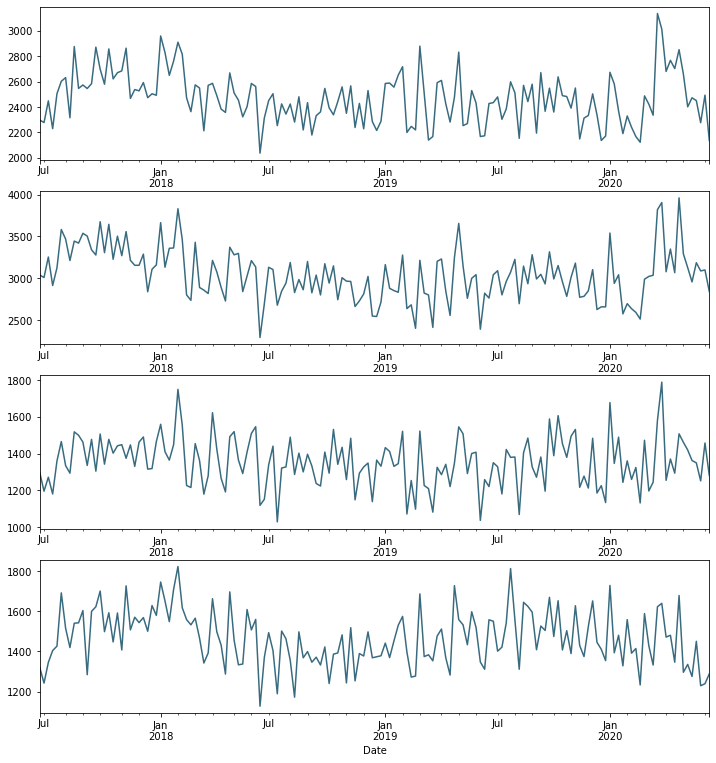

In [51]:
# preparation: input should be float type
df_raw['sales'] = df_raw['sales'] * 1.0

# store types
sales_a = df_raw[df_raw.location == 'North']['sales'].sort_index(ascending = True)
sales_b = df_raw[df_raw.location == 'Central']['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = df_raw[df_raw.location == 'South']['sales'].sort_index(ascending = True)
sales_d = df_raw[df_raw.location == 'East Coast']['sales'].sort_index(ascending = True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
c = '#386B7F'

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)


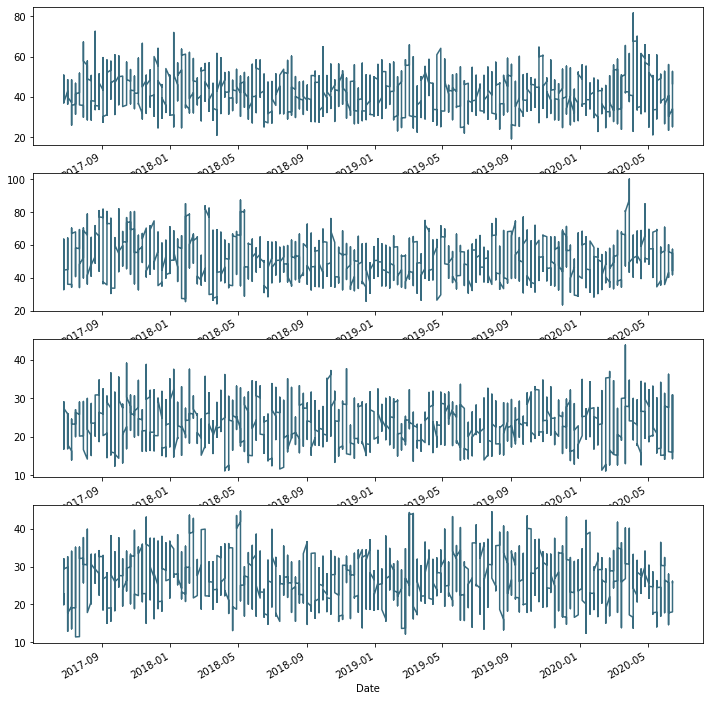

In [52]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Yearly
decomposition_a = sm.tsa.seasonal_decompose(sales_a, model = 'additive', freq = 29)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = sm.tsa.seasonal_decompose(sales_b, model = 'additive', freq = 29)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = sm.tsa.seasonal_decompose(sales_c, model = 'additive', freq = 29)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = sm.tsa.seasonal_decompose(sales_d, model = 'additive', freq = 29)
decomposition_d.trend.plot(color = c, ax = ax4)


In [53]:
date_sales = df_raw.drop(['location','Category'], axis=1).copy() #it's a temporary DataFrame.. Original is Still intact..

In [54]:
y = date_sales['sales'].resample('MS').mean() 
y['2017':] #sneak peak

Date
2017-06-01    34.881579
2017-07-01    36.077324
2017-08-01    38.290635
2017-09-01    38.372863
2017-10-01    39.667244
2017-11-01    38.480519
2017-12-01    37.106126
2018-01-01    39.816720
2018-02-01    38.266094
2018-03-01    35.961790
2018-04-01    36.871080
2018-05-01    36.555191
2018-06-01    34.740416
2018-07-01    35.307557
2018-08-01    34.932609
2018-09-01    35.123586
2018-10-01    35.513043
2018-11-01    34.413115
2018-12-01    33.526863
2019-01-01    36.128649
2019-02-01    33.418202
2019-03-01    35.262009
2019-04-01    35.912281
2019-05-01    37.495082
2019-06-01    34.311189
2019-07-01    36.178844
2019-08-01    35.995657
2019-09-01    37.021834
2019-10-01    36.529794
2019-11-01    35.467249
2019-12-01    33.943429
2020-01-01    36.315676
2020-02-01    32.609358
2020-03-01    40.047111
2020-04-01    39.880979
2020-05-01    36.353562
2020-06-01    34.876652
Freq: MS, Name: sales, dtype: float64

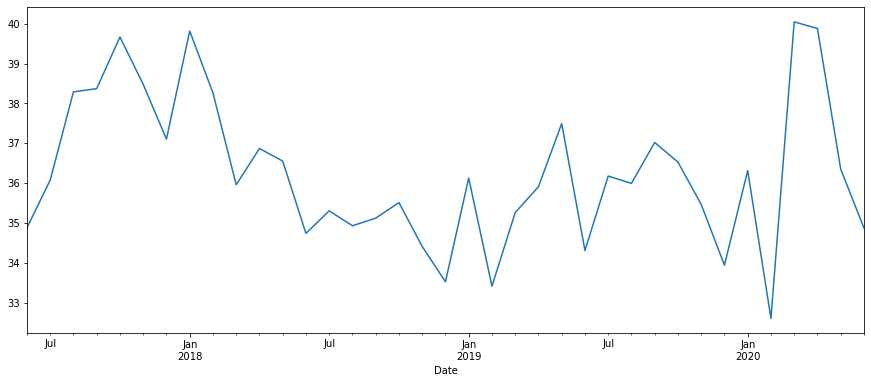

In [55]:
y.plot(figsize=(15, 6),);

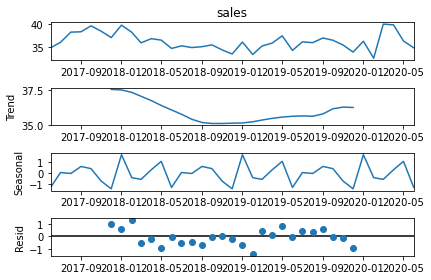

In [56]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot();
#The plot clearly shows that the sales is unstable, along with its obvious seasonality.;


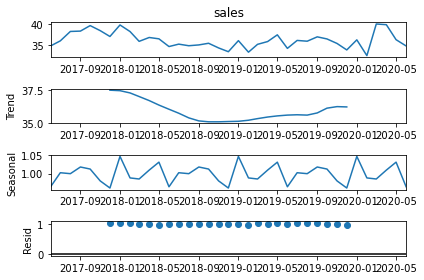

In [57]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot();
#The plot above clearly shows that the sales is unstable, along with its obvious seasonality.;

In [58]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(date_sales, 24) # prediction for the last observed day (past 24 hours)

8.333333333333334

In [59]:
def plotMovingAverage(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, color='Black', label="Rolling mean trend", alpha=0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, color='Black', label="Upper Bond / Lower Bond", alpha=.3)
        plt.plot(lower_bond, color='Black', alpha=.3)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:],color='Red', label="Actual values", alpha=.3)
    plt.legend(loc="upper left")
    plt.grid(True)

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual", alpha = 0.4)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

        

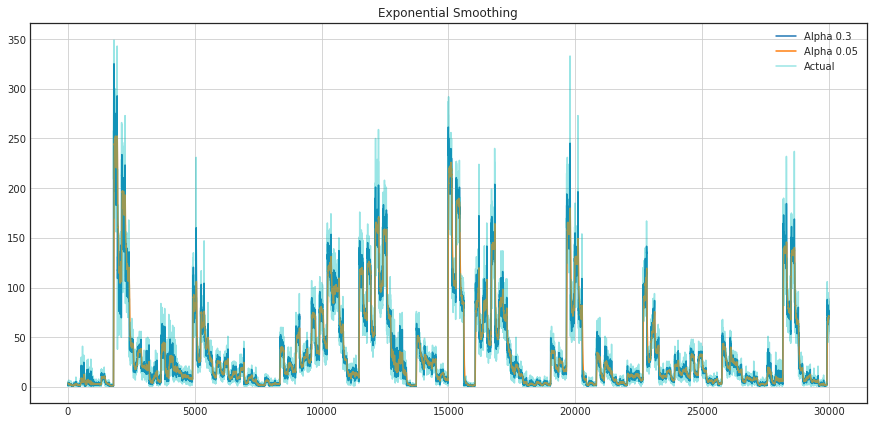

In [60]:
plotExponentialSmoothing(date_sales.sales[:30000], [0.3, 0.05])

In [61]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.1)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

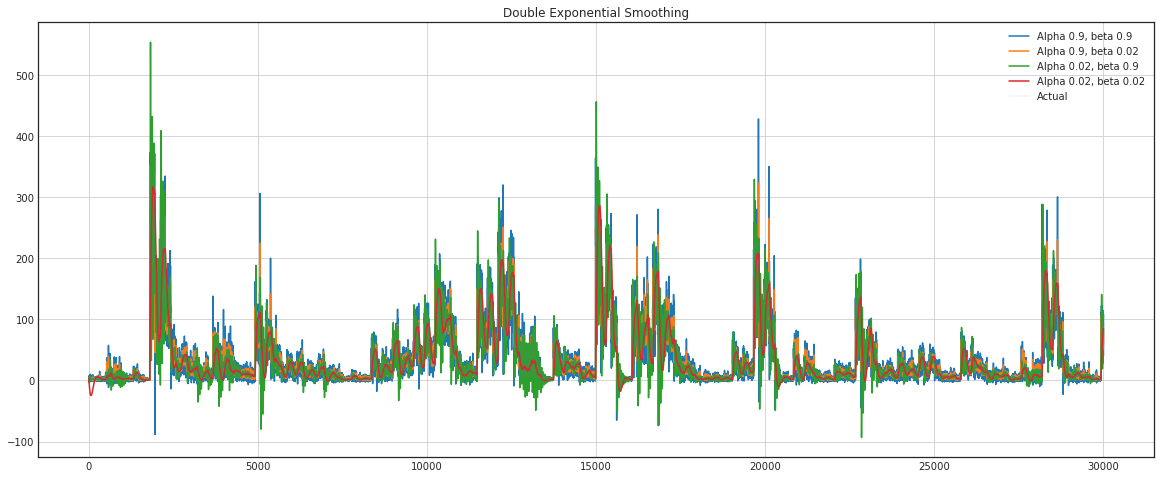

In [62]:
plotDoubleExponentialSmoothing(date_sales.sales[:30000], alphas=[0.9, 0.02], betas=[0.9, 0.02])


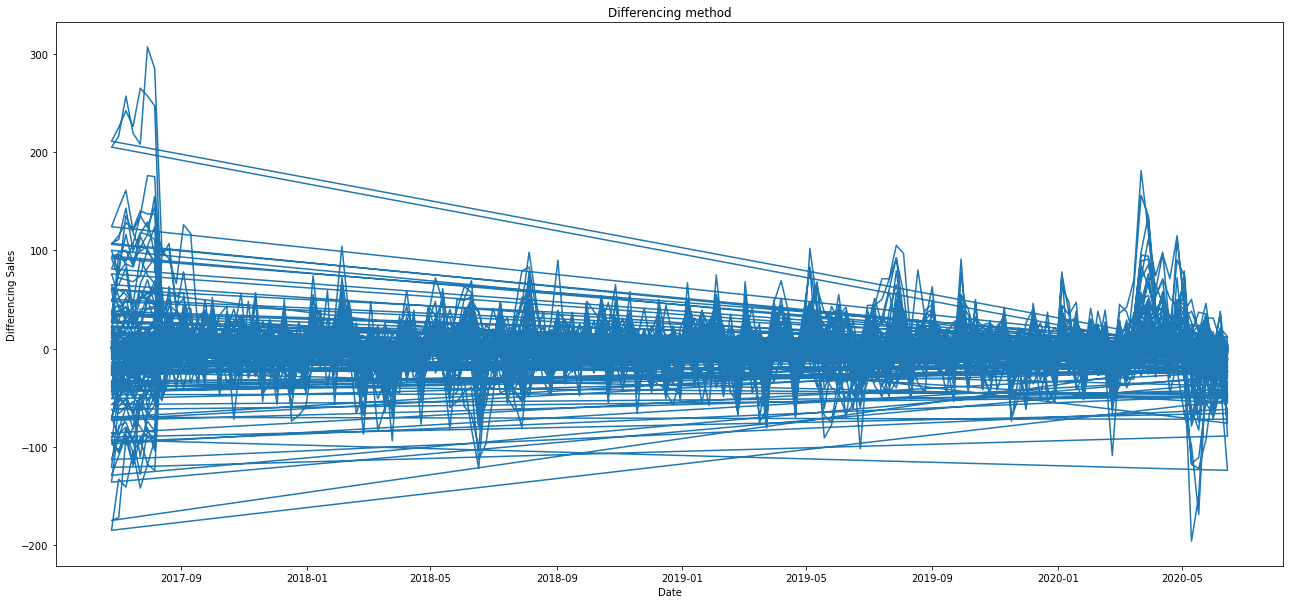

In [63]:
ts_diff = date_sales - date_sales.shift(7)
plt.figure(figsize=(22,10))
plt.plot(ts_diff[:20000])
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Sales");

In [66]:
df_raw = df_raw.reset_index()
test = df[(df['Date'] >'2020-03-16')]
df_test = test.copy()
df_test = df_test.reset_index()

In [67]:
test

,Category,location,Date,sales
127,Baby Cereal,Central,2020-03-22,6
128,Baby Cereal,Central,2020-03-29,1
129,Baby Cereal,Central,2020-04-05,1
130,Baby Cereal,Central,2020-04-12,1
131,Baby Cereal,Central,2020-04-26,1
...,...,...,...,...
35823,Yoghurts,South,2020-05-17,4
35824,Yoghurts,South,2020-05-24,12
35825,Yoghurts,South,2020-05-31,5
35826,Yoghurts,South,2020-06-07,7


In [68]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
        
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_raw,'Date',False)
add_datepart(df_test,'Date',False)


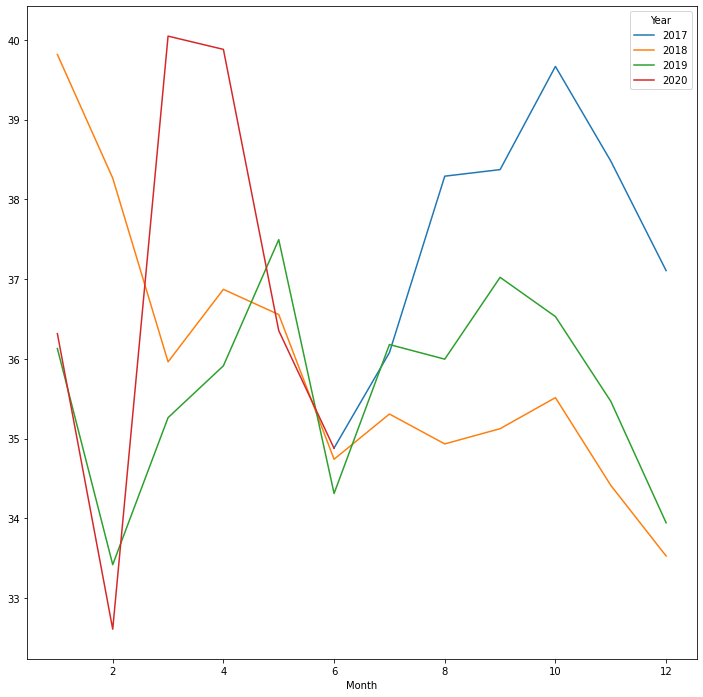

In [69]:
pivoted = pd.pivot_table(df_raw, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

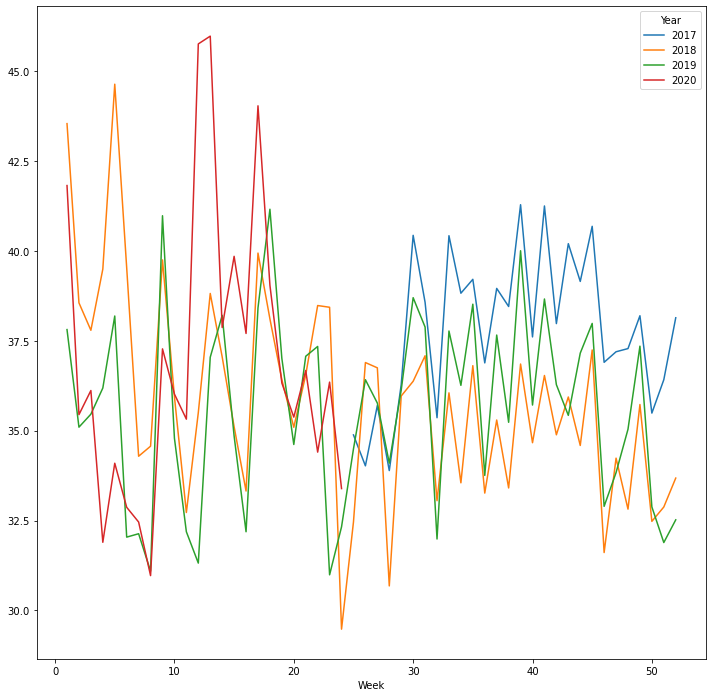

In [70]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

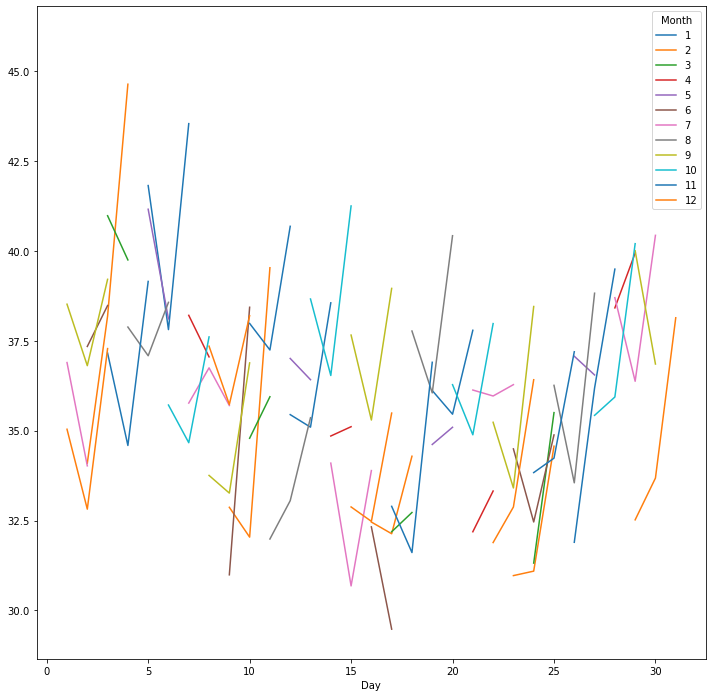

In [71]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12));

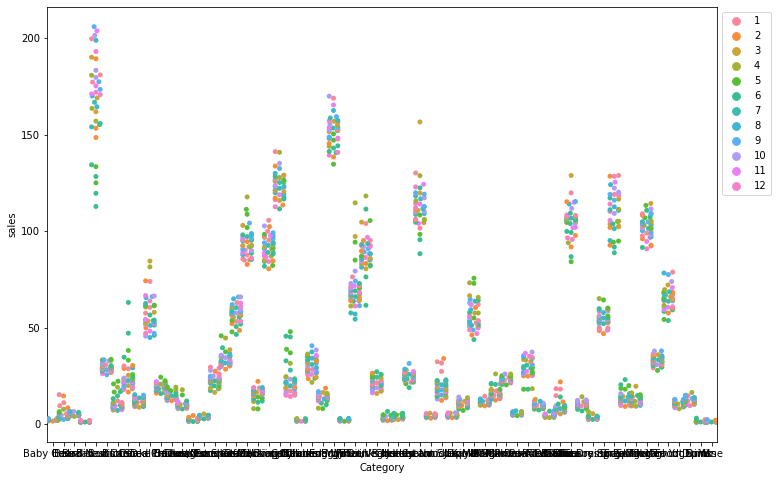

In [72]:
temp_1 = df_raw.groupby(['Year','Month','Category'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8))
sns.swarmplot('Category', 'sales', data=temp_1, hue = 'Month');
# Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2);

<Figure size 864x576 with 0 Axes>

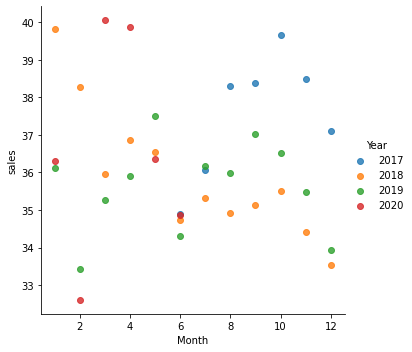

In [73]:
temp_1 = df_raw.groupby(['Year','Month'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.lmplot('Month','sales',data = temp_1, hue='Year', fit_reg= False);

<Figure size 864x576 with 0 Axes>

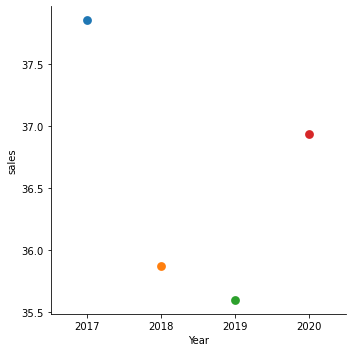

In [74]:
temp_1 = df_raw.groupby(['Year'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.factorplot('Year','sales',data = temp_1, hue='Year', kind='point');

In [75]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [76]:
original_target = df_raw.sales.values
target, lambda_prophet = stats.boxcox(df_raw['sales'] + 1)
len_train=target.shape[0]
merged_df = pd.concat([df_raw, df_test])

In [77]:
merged_df

,index,Date,Category,location,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,0,2017-06-25,Baby Cereal,Central,4.0,2017,6,25,25,6,176,25,False,False,False,False,False,False
1,1,2017-07-02,Baby Cereal,Central,3.0,2017,7,26,2,6,183,26,False,False,False,False,False,False
2,2,2017-07-09,Baby Cereal,Central,4.0,2017,7,27,9,6,190,27,False,False,False,False,False,False
3,3,2017-07-16,Baby Cereal,Central,3.0,2017,7,28,16,6,197,28,False,False,False,False,False,False
4,4,2017-07-23,Baby Cereal,Central,2.0,2017,7,29,23,6,204,29,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,35823,2020-05-17,Yoghurts,South,4.0,2020,5,20,17,6,138,20,False,False,False,False,False,False
2933,35824,2020-05-24,Yoghurts,South,12.0,2020,5,21,24,6,145,21,False,False,False,False,False,False
2934,35825,2020-05-31,Yoghurts,South,5.0,2020,5,22,31,6,152,22,True,False,False,False,False,False
2935,35826,2020-06-07,Yoghurts,South,7.0,2020,6,23,7,6,159,23,False,False,False,False,False,False


In [208]:
## FE

In [78]:
%%time
merged_df["median-store_item"] = merged_df.groupby(["Category", "location"])["sales"].transform("median")
merged_df["mean-store_item"] = merged_df.groupby(["Category", "location"])["sales"].transform("mean")
merged_df["mean-Month_item"] = merged_df.groupby(["Month", "Category"])["sales"].transform("mean")
merged_df["median-Month_item"] = merged_df.groupby(["Month", "Category"])["sales"].transform("median")
merged_df["median-Month_store"] = merged_df.groupby(["Month", "location"])["sales"].transform("median")
merged_df["median-item"] = merged_df.groupby(["Category"])["sales"].transform("median")
merged_df["median-store"] = merged_df.groupby(["location"])["sales"].transform("median")
merged_df["mean-item"] = merged_df.groupby(["Category"])["sales"].transform("mean")
merged_df["mean-store"] = merged_df.groupby(["location"])["sales"].transform("mean")

merged_df["median-store_item-Month"] = merged_df.groupby(['Month', "Category", "location"])["sales"].transform("median")
merged_df["mean-store_item-week"] = merged_df.groupby(["Category", "location",'weekofyear'])["sales"].transform("mean")
merged_df["item-Month-mean"] = merged_df.groupby(['Month', "Category"])["sales"].transform("mean")# mean sales of that item  for all stores scaled
merged_df["store-Month-mean"] = merged_df.groupby(['Month', "location"])["sales"].transform("mean")# mean sales of that store  for all items scaled

# adding more lags (Check the rationale behind this in the links attached)
lags = [90,91,98,105,112,119,126,182,189,364]
for i in lags:
    merged_df['_'.join(['item-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear'])["sales"].transform(lambda x:x.shift(i).sum()) 
    merged_df['_'.join(['item-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear'])["sales"].transform(lambda x:x.shift(i).mean()) 
    merged_df['_'.join(['item-week_shifted-', str(i)])].fillna(merged_df['_'.join(['item-week_shifted-', str(i)])].mode()[0], inplace=True)
    ##### sales for that item i days in the past
    merged_df['_'.join(['store-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear'])["sales"].transform(lambda x:x.shift(i).sum())
    merged_df['_'.join(['store-week_shifted-', str(i)])] = merged_df.groupby(['weekofyear'])["sales"].transform(lambda x:x.shift(i).mean()) 
    merged_df['_'.join(['store-week_shifted-', str(i)])].fillna(merged_df['_'.join(['store-week_shifted-', str(i)])].mode()[0], inplace=True)

CPU times: user 1.92 s, sys: 201 ms, total: 2.12 s
Wall time: 3.03 s


In [79]:
merged_df

,index,Date,Category,location,sales,Year,Month,Week,Day,Dayofweek,...,item-week_shifted-_119,store-week_shifted-_119,item-week_shifted-_126,store-week_shifted-_126,item-week_shifted-_182,store-week_shifted-_182,item-week_shifted-_189,store-week_shifted-_189,item-week_shifted-_364,store-week_shifted-_364
0,0,2017-06-25,Baby Cereal,Central,4.0,2017,6,25,25,6,...,32.720280,32.720280,33.026549,33.026549,33.243615,33.243615,33.270916,33.270916,38.100917,38.100917
1,1,2017-07-02,Baby Cereal,Central,3.0,2017,7,26,2,6,...,34.634276,34.634276,35.000000,35.000000,35.514911,35.514911,35.550403,35.550403,40.632399,40.632399
2,2,2017-07-09,Baby Cereal,Central,4.0,2017,7,27,9,6,...,34.892361,34.892361,35.275923,35.275923,35.822612,35.822612,35.918972,35.918972,41.728097,41.728097
3,3,2017-07-16,Baby Cereal,Central,3.0,2017,7,28,16,6,...,31.772887,31.772887,32.098039,32.098039,32.627723,32.627723,32.724900,32.724900,37.065015,37.065015
4,4,2017-07-23,Baby Cereal,Central,2.0,2017,7,29,23,6,...,35.031690,35.031690,35.360071,35.360071,35.831683,35.831683,35.829317,35.829317,40.808050,40.808050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,35823,2020-05-17,Yoghurts,South,4.0,2020,5,20,17,6,...,36.220945,36.220945,35.693299,35.693299,34.695833,34.695833,34.887798,34.887798,34.144981,34.144981
2933,35824,2020-05-24,Yoghurts,South,12.0,2020,5,21,24,6,...,37.837905,37.837905,37.466667,37.466667,36.254398,36.254398,36.476776,36.476776,36.298025,36.298025
2934,35825,2020-05-31,Yoghurts,South,5.0,2020,5,22,31,6,...,37.318584,37.318584,36.922194,36.922194,36.141484,36.141484,36.384189,36.384189,36.380952,36.380952
2935,35826,2020-06-07,Yoghurts,South,7.0,2020,6,23,7,6,...,36.369620,36.369620,35.886335,35.886335,34.829436,34.829436,35.059722,35.059722,34.179817,34.179817


In [90]:
#df_raw.drop('sales', axis=1, inplace=True)
#merged_df.drop(['Date','sales'], axis=1, inplace=True)
#merged_df.drop(['Category'], axis=1, inplace=True)
merged_df.drop(['location'], axis=1, inplace=True)

In [91]:
merged_df = merged_df * 1
params = {
    'nthread': 4,
    'categorical_feature' : [0,1,9,10,12,13,14], # Day, DayOfWeek, Month, Week, Item, Store, WeekOfYear
    'max_depth': 8,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'num_leaves': 127,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 30,
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1
}


In [92]:
# do the training
num_folds = 3
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target # removing what we did earlier

oof_preds = np.zeros([all_y.shape[0]])
sub_preds = np.zeros([test_x.shape[0]])

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits=num_folds, shuffle=True, random_state=345665)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(all_x)):
    train_x, train_y = all_x[train_idx], all_y[train_idx]
    valid_x, valid_y = all_x[valid_idx], all_y[valid_idx]
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
        
    # train
    gbm = lgb.train(params, lgb_train, 1000, 
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100, verbose_eval=100)
    
    oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
    sub_preds[:] += gbm.predict(test_x, num_iteration=gbm.best_iteration) / folds.n_splits
    valid_idx += 1
    importance_df = pd.DataFrame()
    importance_df['feature'] = merged_df.columns
    importance_df['importance'] = gbm.feature_importance()
    importance_df['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, importance_df], axis=0)

e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score With Box Cox %.4f' %e)
print('Inverting Box Cox Transformation')
print('Done!!')

sub_preds = inverse_boxcox(sub_preds , lambda_prophet) - 1
oof_preds = inverse_boxcox(oof_preds , lambda_prophet) - 1
e = 2 * abs(all_y - oof_preds) / ( abs(all_y)+abs(oof_preds) )
e = e.mean()
print('Full validation score Re-Box Cox Transformation is %.4f' %e)
#Don't Forget to apply inverse box-cox


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.074357	valid_1's mape: 0.0890579
Early stopping, best iteration is:
[30]	training's mape: 0.0804505	valid_1's mape: 0.0875832
Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.074939	valid_1's mape: 0.088495
Early stopping, best iteration is:
[34]	training's mape: 0.0800371	valid_1's mape: 0.087412
Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.0746537	valid_1's mape: 0.0888535
Early stopping, best iteration is:
[34]	training's mape: 0.0797769	valid_1's mape: 0.087374
Full validation score With Box Cox 0.0859
Inverting Box Cox Transformation
Done!!
Full validation score Re-Box Cox Transformation is 1.3528


In [93]:
feature_importance_df.head()

,feature,importance,fold
0,index,0,1
1,Year,113,1
2,Month,41,1
3,Week,97,1
4,Day,280,1


In [95]:
importance_df.sort_values(['importance'], ascending=False, inplace=True);


In [96]:
def plot_fi(fi): 
    return fi.plot('feature', 'importance', 'barh', figsize=(12,12), legend=False)


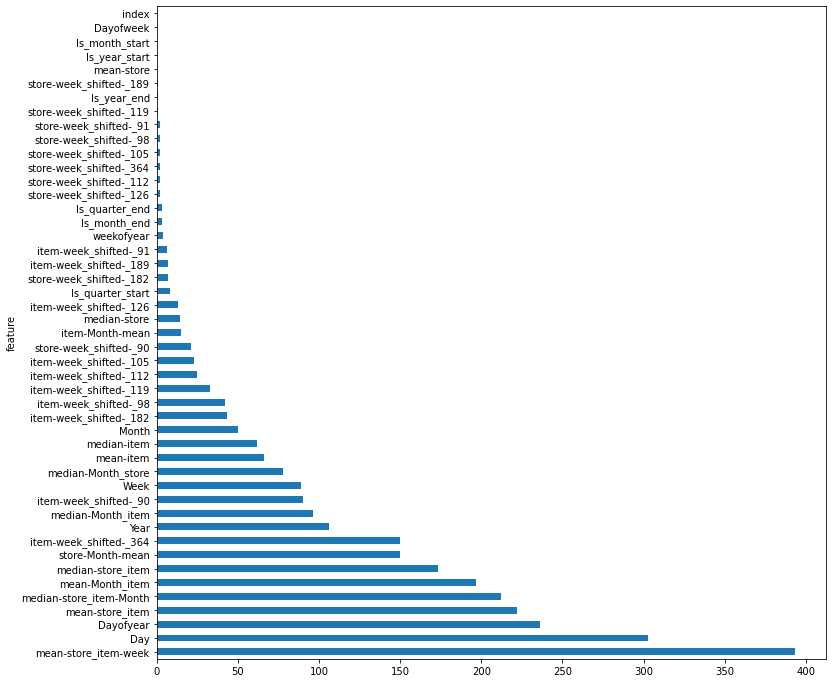

In [97]:
plot_fi(importance_df[:]);


In [100]:
# OHE FOR 0,1,9,10,12,13,14  Cols - Day, Dayofweek, Month, Week, item, store, weekofyear
print("Before OHE", merged_df.shape)
merged_df = pd.get_dummies(merged_df, columns=['Day', 'Dayofweek', 'Month', 'Week', 'weekofyear'])
print("After OHE", merged_df.shape)
test_x = merged_df[len_train:].values
all_x = merged_df[:len_train].values
all_y = target;

Before OHE (38765, 47)
After OHE (38765, 190)


In [101]:
def XGB_regressor(train_X, train_y, test_X, test_y= None, feature_names=None, seed_val=2018, num_rounds=500):

    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.1
    param['max_depth'] = 5
    param['silent'] = 1
    param['eval_metric'] = 'mae'
    param['min_child_weight'] = 4
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X, label=train_y)
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model    


In [103]:
model = XGB_regressor(train_X = all_x, train_y = all_y, test_X = test_x)
y_test = model.predict(xgb.DMatrix(test_x), ntree_limit = model.best_ntree_limit)

[15:31:36] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:49] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


In [104]:
print('Inverting Box Cox Transformation')
y_test = inverse_boxcox(y_test, lambda_prophet) - 1


Inverting Box Cox Transformation


In [106]:
df = date_sales.reset_index()
df.columns = ['ds', 'y']

In [107]:
df.head()


,ds,y
0,2017-06-25,4.0
1,2017-07-02,3.0
2,2017-07-09,4.0
3,2017-07-16,3.0
4,2017-07-23,2.0


In [109]:
df['location'] = df_raw['location'].copy()
df['Week'] = df_raw['Week'].copy()
df['Category'] = df_raw['Category'].copy()

In [112]:
df

,ds,y,location,Week,Category
0,2017-06-25,4.0,Central,25,Baby Cereal
1,2017-07-02,3.0,Central,26,Baby Cereal
2,2017-07-09,4.0,Central,27,Baby Cereal
3,2017-07-16,3.0,Central,28,Baby Cereal
4,2017-07-23,2.0,Central,29,Baby Cereal
...,...,...,...,...,...
35823,2020-05-17,4.0,South,20,Yoghurts
35824,2020-05-24,12.0,South,21,Yoghurts
35825,2020-05-31,5.0,South,22,Yoghurts
35826,2020-06-07,7.0,South,23,Yoghurts


In [124]:
df_1 = df[df['Category'] == 'Yoghurts']
df_2 = df_1[df_1['location'] == 'Central']

In [125]:
df_2

,ds,y,location,Week,Category
35207,2017-06-25,14.0,Central,25,Yoghurts
35208,2017-07-02,29.0,Central,26,Yoghurts
35209,2017-07-09,19.0,Central,27,Yoghurts
35210,2017-07-16,18.0,Central,28,Yoghurts
35211,2017-07-23,18.0,Central,29,Yoghurts
...,...,...,...,...,...
35358,2020-05-17,27.0,Central,20,Yoghurts
35359,2020-05-24,30.0,Central,21,Yoghurts
35360,2020-05-31,24.0,Central,22,Yoghurts
35361,2020-06-07,28.0,Central,23,Yoghurts


In [153]:
df_2.groupby(['Week','location','Category'])['y'].mean().reset_index().head(10)


,Week,location,Category,y
0,1,Central,Yoghurts,24.333333
1,2,Central,Yoghurts,26.333333
2,3,Central,Yoghurts,25.333333
3,4,Central,Yoghurts,16.000000
4,5,Central,Yoghurts,25.000000
5,6,Central,Yoghurts,23.666667
6,7,Central,Yoghurts,23.666667
7,8,Central,Yoghurts,20.666667
8,9,Central,Yoghurts,28.666667
9,10,Central,Yoghurts,22.000000


In [159]:
prediction_size = 31 
train_df = df_2[:-prediction_size]
train_df.tail(n=3)

,ds,y,location,Week,Category
35329,2019-10-27,16.0,Central,43,Yoghurts
35330,2019-11-03,30.0,Central,44,Yoghurts
35331,2019-11-10,28.0,Central,45,Yoghurts


In [160]:
%%time
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(train_df[['ds','y']]);

CPU times: user 62.2 ms, sys: 5.7 ms, total: 67.9 ms
Wall time: 69.6 ms


In [161]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
153,2019-12-09
154,2019-12-10
155,2019-12-11


In [162]:
%%time
forecast = m.predict(future)
forecast.tail(n=3)


CPU times: user 1.66 s, sys: 20.1 ms, total: 1.68 s
Wall time: 1.75 s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
153,2019-12-09,18.055794,10.713045,25.025699,18.055655,18.055873,-0.131202,-0.131202,-0.131202,4.069308,...,-0.508663,-0.508663,-0.508663,-3.691846,-3.691846,-3.691846,0.0,0.0,0.0,17.924593
154,2019-12-10,18.059297,10.296633,25.092146,18.059148,18.059382,-0.219190,-0.219190,-0.219190,4.069308,...,-0.508663,-0.508663,-0.508663,-3.779834,-3.779834,-3.779834,0.0,0.0,0.0,17.840107
155,2019-12-11,18.062800,10.528049,24.622169,18.062639,18.062891,-0.263680,-0.263680,-0.263680,4.069308,...,-0.508663,-0.508663,-0.508663,-3.824324,-3.824324,-3.824324,0.0,0.0,0.0,17.799120


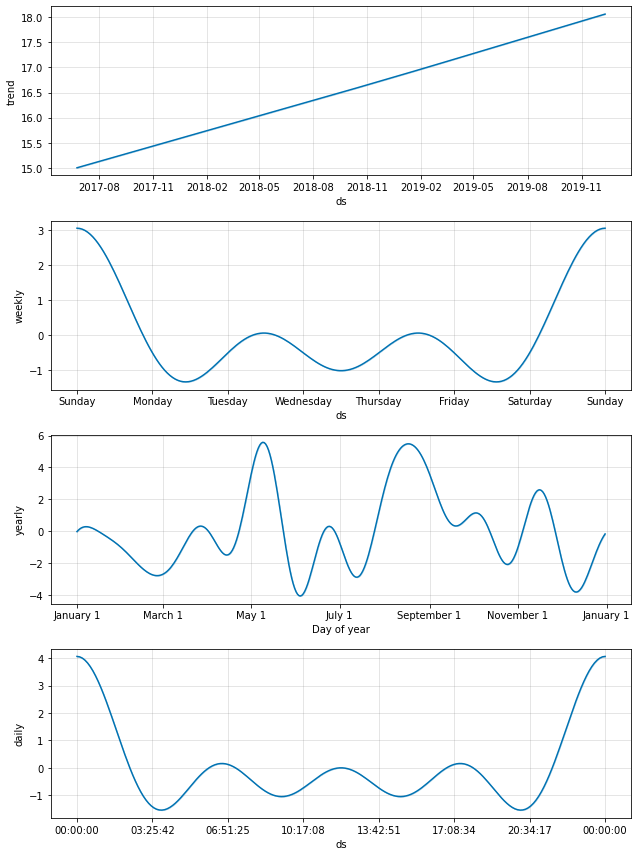

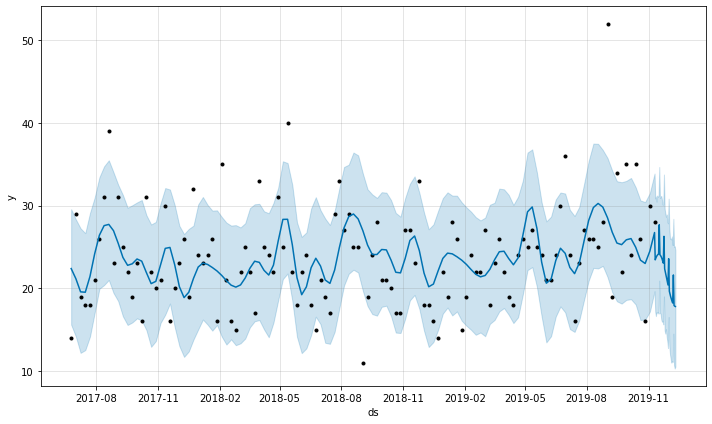

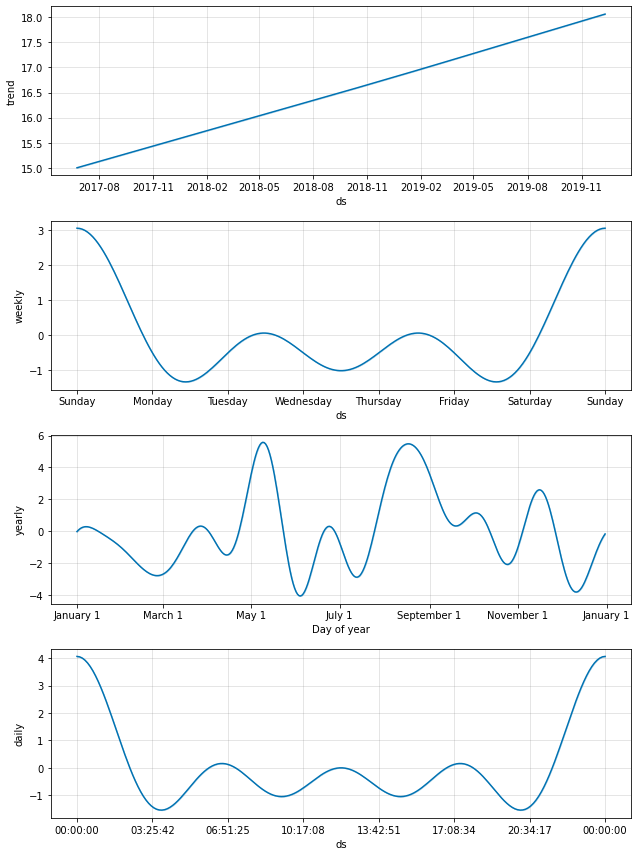

In [163]:
m.plot(forecast)
m.plot_components(forecast)

In [164]:
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
    'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))


In [165]:
%%time
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(train_df[['ds','y']]);


CPU times: user 252 ms, sys: 10.9 ms, total: 263 ms
Wall time: 287 ms


In [166]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
153,2019-12-09
154,2019-12-10
155,2019-12-11


In [167]:
%%time
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

CPU times: user 1.79 s, sys: 22.9 ms, total: 1.82 s
Wall time: 1.88 s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
153,2019-12-09,18.343382,11.637307,25.697248,18.343377,18.343388,0.036081,0.036081,0.036081,3.932135,...,-0.491517,-0.491517,-0.491517,-3.404537,-3.404537,-3.404537,0.0,0.0,0.0,18.379463
154,2019-12-10,18.347154,10.585734,25.182855,18.347148,18.347161,-0.250876,-0.250876,-0.250876,3.932135,...,-0.491517,-0.491517,-0.491517,-3.691495,-3.691495,-3.691495,0.0,0.0,0.0,18.096278
155,2019-12-11,18.350926,10.955291,24.808592,18.350920,18.350933,-0.505934,-0.505934,-0.505934,3.932135,...,-0.491517,-0.491517,-0.491517,-3.946553,-3.946553,-3.946553,0.0,0.0,0.0,17.844992


In [168]:
#from the docs..
forecast_holi[(forecast_holi['playoff'] + forecast_holi['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2,2017-07-09,-0.053653,0.000000
20,2017-11-12,0.000000,5.179437
22,2017-11-26,0.000000,-2.728879
26,2017-12-24,10.654560,0.000000


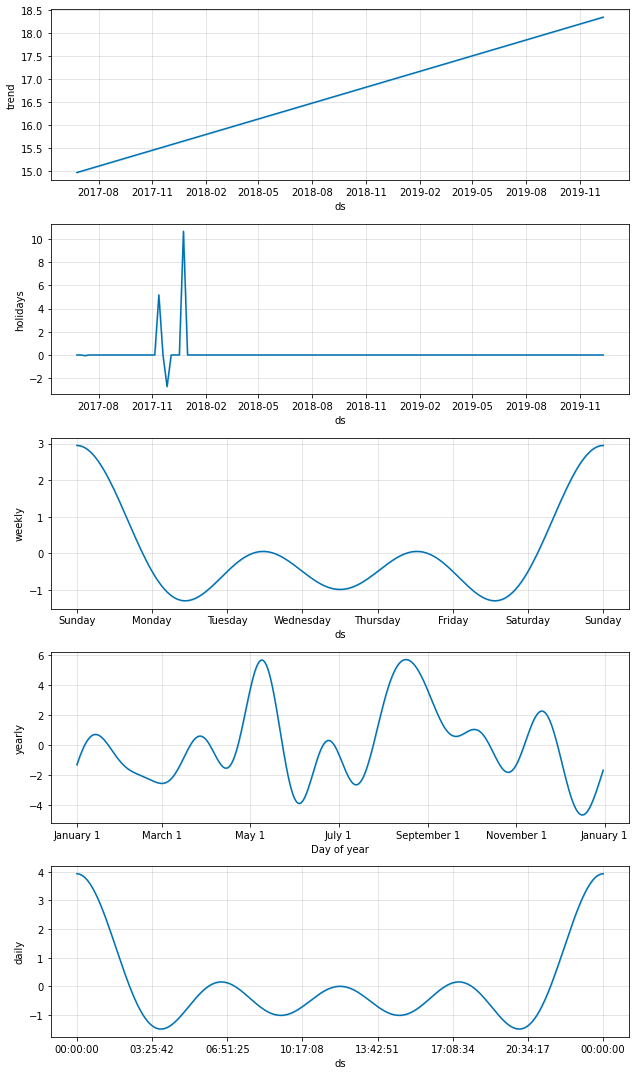

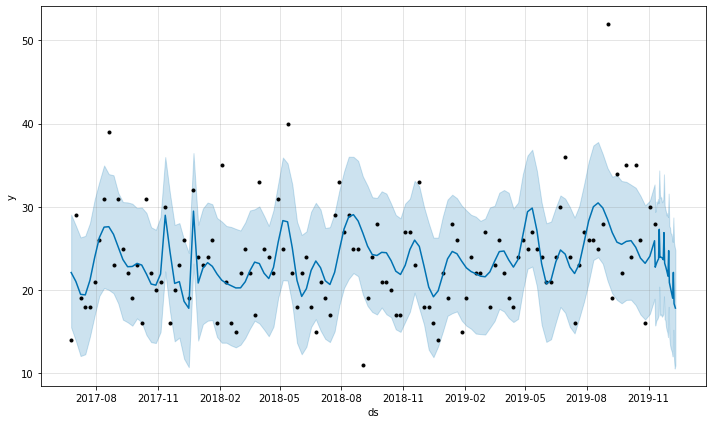

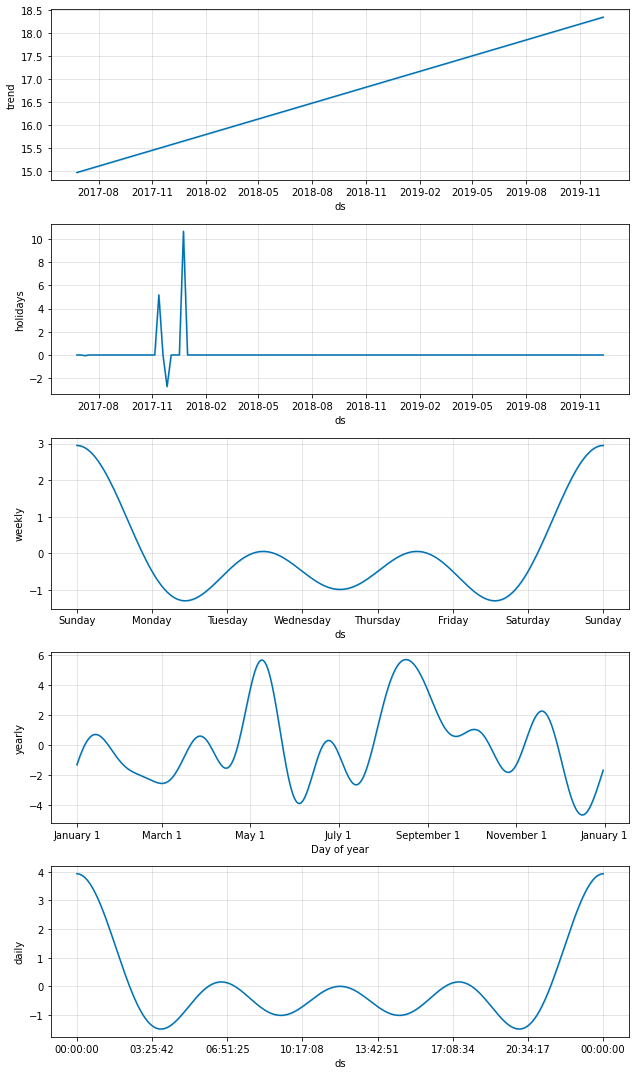

In [169]:
m_holi.plot(forecast_holi)
m_holi.plot_components(forecast_holi)

In [170]:
print(', '.join(forecast.columns))


ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,location,Week,Category
0,2017-06-25,15.000573,15.601141,29.565638,15.000573,15.000573,7.388393,7.388393,7.388393,4.069308,...,0.267104,0.267104,0.0,0.0,0.0,22.388966,14.0,Central,25,Yoghurts
1,2017-07-02,15.023925,14.165656,28.329809,15.023925,15.023925,6.140501,6.140501,6.140501,4.069308,...,-0.980787,-0.980787,0.0,0.0,0.0,21.164427,29.0,Central,26,Yoghurts
2,2017-07-09,15.047277,12.191373,27.248968,15.047277,15.047277,4.524093,4.524093,4.524093,4.069308,...,-2.597196,-2.597196,0.0,0.0,0.0,19.571370,19.0,Central,27,Yoghurts
3,2017-07-16,15.070629,12.528352,26.667328,15.070629,15.070629,4.453061,4.453061,4.453061,4.069308,...,-2.668228,-2.668228,0.0,0.0,0.0,19.523690,18.0,Central,28,Yoghurts
4,2017-07-23,15.093981,14.172336,29.100542,15.093981,15.093981,6.340111,6.340111,6.340111,4.069308,...,-0.781178,-0.781178,0.0,0.0,0.0,21.434092,18.0,Central,29,Yoghurts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2019-11-10,17.954221,19.645674,33.874387,17.954221,17.954221,8.788918,8.788918,8.788918,4.069308,...,1.667630,1.667630,0.0,0.0,0.0,26.743139,28.0,Central,45,Yoghurts
125,2019-11-17,17.978739,20.925363,34.667530,17.978738,17.978739,9.701757,9.701757,9.701757,4.069308,...,2.580468,2.580468,0.0,0.0,0.0,27.680496,21.0,Central,46,Yoghurts
126,2019-11-24,18.003256,19.022731,33.758812,18.003227,18.003262,8.281461,8.281461,8.281461,4.069308,...,1.160172,1.160172,0.0,0.0,0.0,26.284717,25.0,Central,47,Yoghurts
127,2019-12-01,18.027774,16.525459,30.832884,18.027698,18.027808,5.551067,5.551067,5.551067,4.069308,...,-1.570222,-1.570222,0.0,0.0,0.0,23.578841,18.0,Central,48,Yoghurts


In [186]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    tester123 = pd.merge(forecast, df_2, on=['ds'])
    return tester123.set_index('ds')

In [187]:
cmp_df = make_comparison_dataframe(df_2, forecast)
cmp_df.tail(3)

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,location,Week,Category
ds,,,,,,,,,,,,,,,,,,,,,
2019-11-24,18.003256,19.022731,33.758812,18.003227,18.003262,8.281461,8.281461,8.281461,4.069308,4.069308,...,1.160172,1.160172,0.0,0.0,0.0,26.284717,25.0,Central,47,Yoghurts
2019-12-01,18.027774,16.525459,30.832884,18.027698,18.027808,5.551067,5.551067,5.551067,4.069308,4.069308,...,-1.570222,-1.570222,0.0,0.0,0.0,23.578841,18.0,Central,48,Yoghurts
2019-12-08,18.052292,14.513495,28.395582,18.052162,18.052364,3.561127,3.561127,3.561127,4.069308,4.069308,...,-3.560162,-3.560162,0.0,0.0,0.0,21.613419,19.0,Central,49,Yoghurts


In [191]:
cmp_df_holi = make_comparison_dataframe(df, forecast_holi)
cmp_df_holi.tail(3)


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,location,Week,Category
ds,,,,,,,,,,,,,,,,,,,,,
2019-11-24,18.286803,19.258871,33.900691,18.286802,18.286804,8.620628,8.620628,8.620628,3.932135,3.932135,...,1.739391,1.739391,0.0,0.0,0.0,26.907431,25.0,Central,47,Yoghurts
2019-12-01,18.313207,17.995221,31.590073,18.313204,18.313209,6.434035,6.434035,6.434035,3.932135,3.932135,...,-0.447202,-0.447202,0.0,0.0,0.0,24.747242,18.0,Central,48,Yoghurts
2019-12-08,18.339611,15.237588,28.725195,18.339606,18.339616,3.792184,3.792184,3.792184,3.932135,3.932135,...,-3.089053,-3.089053,0.0,0.0,0.0,22.131794,19.0,Central,49,Yoghurts


In [192]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}


In [193]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print('Non Holiday', err_name, err_value)


Non Holiday MAPE 16.878541571939433
Non Holiday MAE 4.593999218424001


In [194]:
for err_name, err_value in calculate_forecast_errors(cmp_df_holi, prediction_size).items():
    print('Including Holiday', err_name, err_value)

Including Holiday MAPE 17.414323082292785
Including Holiday MAE 4.7003306317617914


In [195]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}
    

In [196]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print('Non Holiday', err_name, err_value)

Non Holiday MAPE 16.878541571939433
Non Holiday MAE 4.593999218424001


In [197]:
for err_name, err_value in calculate_forecast_errors(cmp_df_holi, prediction_size).items():
    print('Including Holiday', err_name, err_value)


Including Holiday MAPE 17.414323082292785
Including Holiday MAE 4.7003306317617914


In [198]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='sales'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'Sales on Store $1$ for Item $1$')


In [199]:
show_forecast(cmp_df_holi, prediction_size, 100, 'Sales on Store $1$ for Item $1$ Holidays Version')